# Time to Earthquake Prediction Kernel

### Importing the training data

In [1]:
import numpy as np 
import pandas as pd 

from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from scipy import stats

%matplotlib inline

In [2]:
train_data = pd.read_csv('../input/train.csv',dtype={'acoustic_data': np.int16,
                                                     'time_to_failure':np.float64})

The difference between the values of the time_to_failure is very small. Therefore, we need to have more precision in the data.

In [3]:
pd.options.display.precision = 15
train_data.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [4]:
train_data.shape

(629145480, 2)

Since the data is so large we extract and plot the data that includes the first seismic event. Below, we can see that there is a lag between the time of the occurance of a large acoustic pulse and when the seismic event happens (time to earthquake reaches zero). 

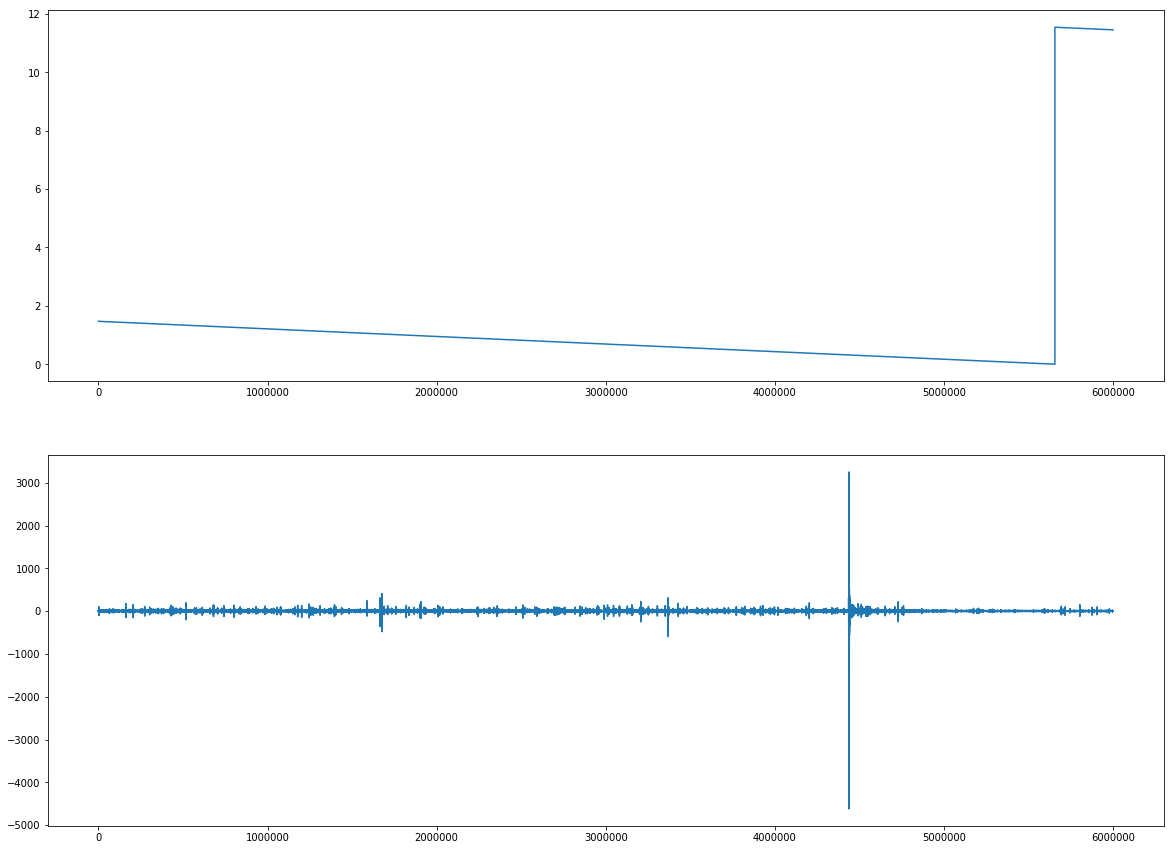

In [5]:
fig, ax = plt.subplots(2,1, figsize=(20,15))
ax[1].plot(train_data.index[:6000000], train_data['acoustic_data'].values[:6000000]);
ax[0].plot(train_data.index[:6000000], train_data['time_to_failure'].values[:6000000]);


## Data Visualisation

The data is recorded in segments at a frequency of 4MHz, each segment lasts 0.0375 seconds. Therefore,  including 150,000 data points

In [6]:
segment_size = 150000
num_segments = int(np.floor(train_data.shape[0]/segment_size))

X_train = pd.DataFrame(index=range(num_segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(num_segments), dtype=np.float64,
                       columns=['time_to_failure'])

There are several features added to the input features below. Most of them are extracted from the exisitng kernels at Kaggle including the one for Gabriel Preda: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [7]:
def create_features(segment, seg, X_tr):
    x = pd.Series(seg['acoustic_data'].values)
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()

    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    z = np.fft.fft(x)
    
    realFFT = np.real(z)
    imagFFT = np.imag(z)
    X_tr.loc[segment, 'A0'] = abs(z[0])
    X_tr.loc[segment, 'Real_mean'] = realFFT.mean()
    X_tr.loc[segment, 'Real_std'] = realFFT.std()
    X_tr.loc[segment, 'Real_max'] = realFFT.max()
    X_tr.loc[segment, 'Real_min'] = realFFT.min()
    X_tr.loc[segment, 'Imag_mean'] = imagFFT.mean()
    X_tr.loc[segment, 'Imag_std'] = imagFFT.std()
    X_tr.loc[segment, 'Imag_max'] = imagFFT.max()
    X_tr.loc[segment, 'Imag_min'] = imagFFT.min()
    
    
    for windows in [10,100,1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [8]:
for seg_id in tqdm_notebook(range(num_segments)):
    seg = train_data.iloc[seg_id*segment_size:seg_id*segment_size+segment_size]
    create_features(seg_id, seg, X_train)
    y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide
/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


## Training and Validation

### Scaling the training data

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,mean,std,max,min,mean_change_abs,abs_max,std_first_50000,std_last_50000,std_first_10000,std_last_10000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,-1.326419602086939,-0.222566817896606,0.052067120339060,-0.285578802588458,0.724222502558045,-0.192422289131222,...,0.268470130890001,-0.004741890462161,0.178277723969481,0.287332145975991,0.965402446610929,1.509153430549683,0.885262121712506,-0.631300343511894,-1.832422175860377,-0.004741890462161
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.002746647790241,0.036796505974809,0.153858292399954,-0.076987041316589,-0.195868738188691,-0.310469522417300,...,-0.141264321988320,0.007341389309125,-0.025386948237320,0.622391465890732,0.842747052156309,0.522427542165818,0.294356817530996,-0.912053970881953,-0.890022480697742,0.007341389309125
2,1.511155259373638,0.049252196732055,-0.086288799593083,0.163038834290874,-0.218781060522623,-0.101306043099581,0.004240793200813,0.277885119361809,0.373966634870483,0.681221764981943,...,0.085078050610279,0.099555892826834,0.245184093558079,0.634878148620475,1.207105723918564,1.530919442793446,0.889790131706233,0.441127926802558,0.639209280695772,0.099555892826834
3,1.494934375107487,0.043949637951170,0.122560323147863,-0.187796120136112,0.002746647790241,0.097426893373321,0.020851954621430,-0.058805334800357,0.171819935350774,-0.191907658557101,...,0.083084874365199,0.068075769212167,0.105059432721582,0.770150544859347,1.160208073097680,1.432972387696517,0.815077966809722,-0.949993650256284,-1.097513494373596,0.068075769212167
4,1.520242078970568,0.088495070341074,-0.067968701107035,0.087590456994748,-0.108017206366191,-0.084464268822216,-0.093103984672099,0.174161254562638,-0.044711924997726,1.006489344306537,...,-0.164150560726067,0.138031599466982,0.187535209069790,1.040695337337088,1.557034349274394,1.393068031916287,0.901110156690553,0.595415956258175,-0.465464227208672,0.138031599466982


We check out the correlation of the features with the target column. Here we only show the values below 0.1. It shows that famous statistics such as median, mean, skew and sum are extremly random and thus un related to the target feature. Since there are only two features with correlations between 0.05 and 0.1 we keep the two and drop the ones with correlations below 0.05.

In [32]:
temp=pd.DataFrame.from_records(X_train_scaled,columns=X_train_scaled.columns)
correlations=temp.corrwith(y_train.time_to_failure, axis = 0).abs().sort_values().dropna()
correlations[correlations<0.1]

mean_change_abs                  0.000035751220635
Real_mean                        0.000449864180718
av_change_abs_roll_std_100       0.001201948205031
av_change_rate_roll_std_10       0.002817381746464
max_to_min_diff                  0.004148848003472
med                              0.004445002956765
av_change_rate_roll_std_100      0.004983328606673
av_change_rate_roll_mean_10      0.005539041853078
av_change_abs_roll_std_1000      0.005986686874126
av_change_rate_roll_std_1000     0.007707037486454
av_change_rate_roll_mean_1000    0.007890391661523
av_change_rate_roll_mean_100     0.008108470673970
av_change_abs_roll_std_10        0.008280762039733
av_change_abs_roll_mean_100      0.009184950168258
abs_q05                          0.011190551901536
q05_roll_mean_1000               0.011795942113581
skew                             0.015573660401806
av_change_abs_roll_mean_1000     0.016239757934263
avg_last_10000                   0.016960267530172
Imag_mean                      

In [33]:
columns_to_drop = correlations[correlations<0.05].index
X_train_scaled = X_train_scaled.drop(columns_to_drop, axis=1)

In [34]:
X_train_scaled.shape

(4194, 93)

35 features has been dropped which were of little use.

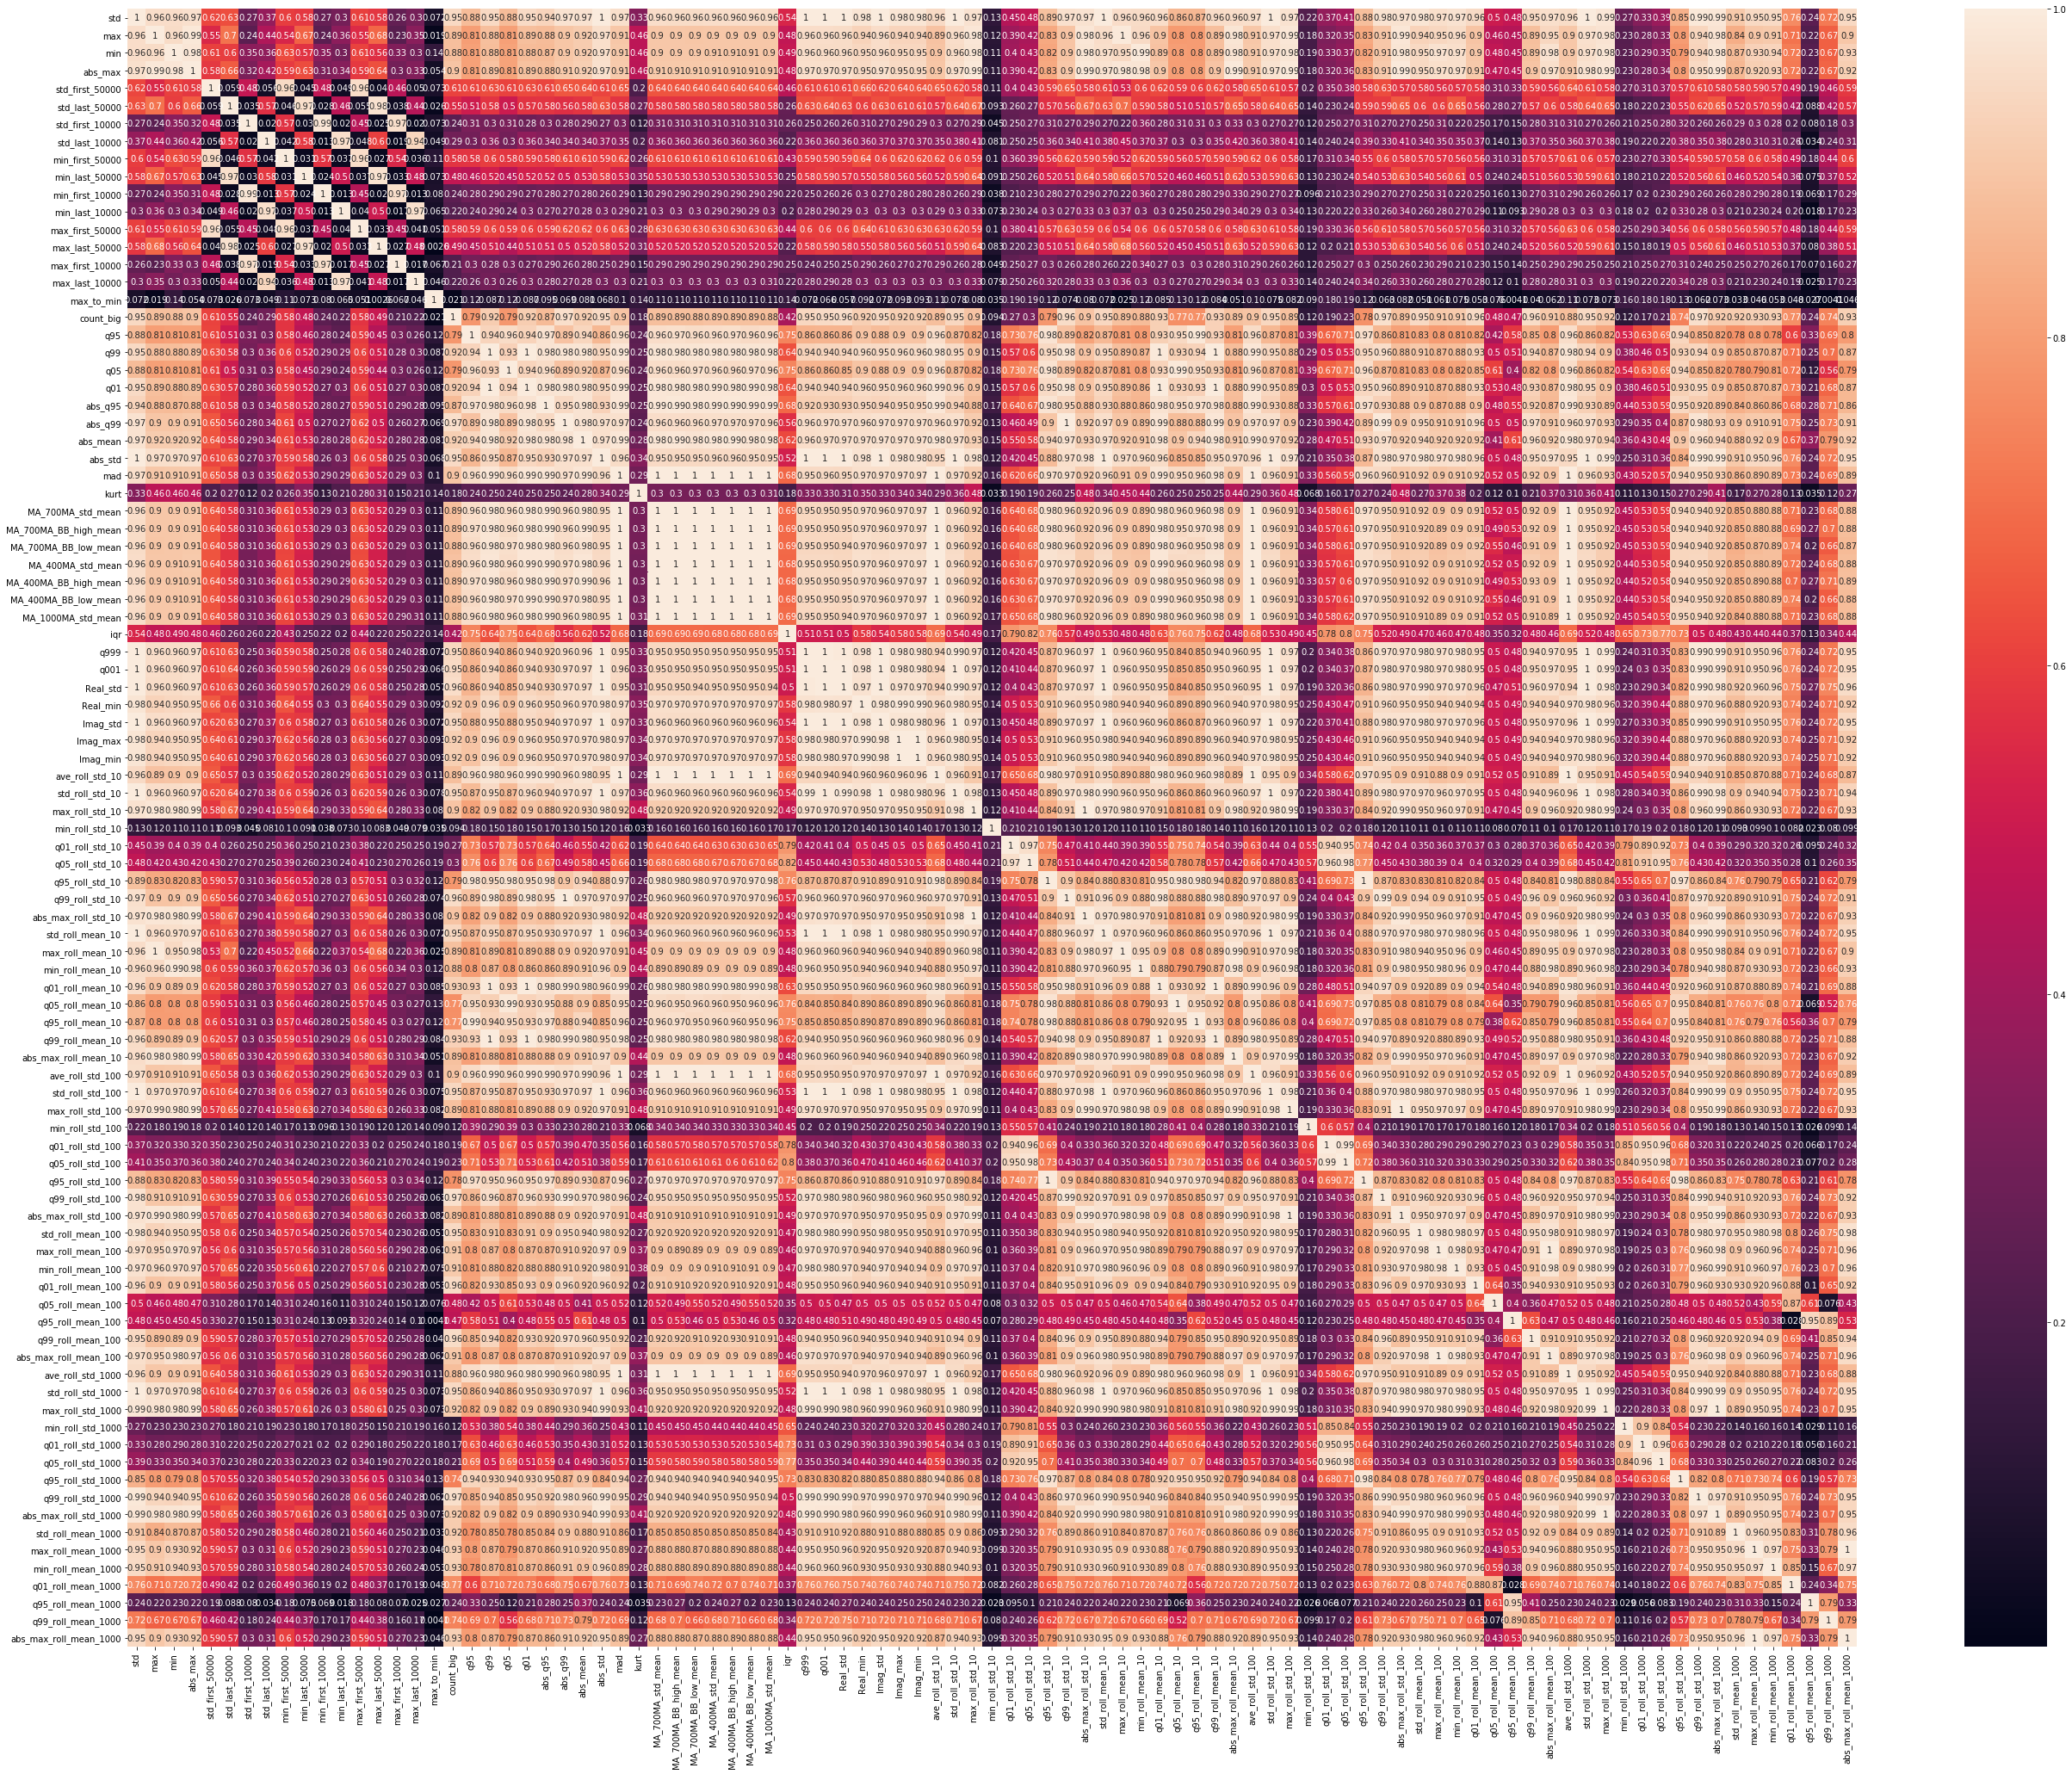

In [13]:
import seaborn as sns
plt.figure(figsize=[45,35])
sns.heatmap(X_train_scaled.corr().abs(), annot=True);

The heatmap results show a very large correlation between the exisitng features and it is due to the same concept and statistics among many of the features.

In [14]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


In [15]:
submission_files = pd.read_csv('../input/sample_submission.csv',index_col='seg_id')
submission_files

X_test = pd.DataFrame(columns=X_train.columns,index=submission_files.index,dtype=np.float64)

for seg_id in tqdm_notebook(X_test.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

X_test.head()

/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide
/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


,mean,std,max,min,mean_change_abs,abs_max,std_first_50000,std_last_50000,std_first_10000,std_last_10000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.893689687028083,115.0,-75.0,0.000026666844446,115.0,5.350451034532085,4.793875620462976,5.226846310370645,6.019017079778115,...,0.231890979668247,5.495,3.774,3.889,4.099,4.867,5.000,0.000001778523490,74583.596158882588497,5.495
seg_0012b5,4.171153333333334,5.922839443206501,152.0,-140.0,-0.000013333422223,152.0,6.249515353148833,4.147562311992749,3.523252628028267,3.605147356037735,...,0.230913661347393,5.009,3.342,3.644,3.790,4.541,4.739,-0.000000194630872,74346.833284796943190,5.009
seg_00184e,4.610260000000000,6.946990077499337,248.0,-193.0,-0.000020000133334,248.0,9.793473000415542,5.225913486026655,3.950118644259989,3.063057033722876,...,0.247219261166618,6.234,3.544,4.013,4.215,4.966,5.082,0.000000080536913,74349.464458851696691,6.234
seg_003339,4.531473333333333,4.114146602958790,85.0,-93.0,0.000046666977780,93.0,3.664087695507956,3.480839857925430,4.001275479212355,2.771184892166283,...,0.224908762860213,5.446,3.889,4.032,4.184,4.911,5.051,0.000003899328859,74430.046482895355439,5.446
seg_0042cc,4.128340000000000,5.797163636219714,177.0,-147.0,-0.000006666711111,177.0,5.321132797542735,7.486142223395690,5.214577944792295,6.871186514017142,...,0.274025292743740,5.027,3.357,3.534,3.662,4.570,4.870,-0.000002939597315,74545.727161125323619,5.027


In [81]:
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,
                             index = submission_files.index)
X_test_scaled.head()

,mean,std,max,min,mean_change_abs,abs_max,std_first_50000,std_last_50000,std_first_10000,std_last_10000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,1.360262645399913,-0.204789818851898,-0.183328133315848,0.271521751348082,0.457118310391062,-0.188242059567506,-0.095468613734637,-0.297401993517014,-0.038798541284963,0.115657281997071,...,-0.123289656802347,0.047739937739601,0.229347280843346,0.639451900883898,1.286196140095345,1.147463648035053,0.610019039259539,0.709554444200400,0.563180692658607,0.047739937739601
seg_0012b5,0.089336994250243,-0.087078110378473,-0.049495315238573,0.048399781055784,-0.268445827001506,-0.068265396537965,-0.031543955466708,-0.453902378600770,-0.187473003228249,-0.410359855238111,...,-0.128902528305887,-0.078659713383204,0.090380193653731,0.155712043596526,0.176446445737960,-0.033307467426788,0.038709916881089,-0.054817992794369,-1.054535425758502,-0.078659713383204
seg_00184e,1.829903155073301,0.030061810389143,0.297746591124085,-0.133530440874860,-0.389373183233601,0.243025404835980,0.220436105165761,-0.192786953960554,-0.150219944624589,-0.528489179560183,...,-0.035257259798587,0.239940230290534,0.155360174237764,0.884283502123221,1.702801203349249,1.506041379417638,0.789510794183036,0.051778163385173,-1.036557553614595,0.239940230290534
seg_003339,1.517602257969986,-0.293952108114035,-0.291841229054179,0.209734128805599,0.819900379087347,-0.259579534882369,-0.215371270230378,-0.615344699899230,-0.145755432346751,-0.592092342079825,...,-0.163389473737240,0.034995939992652,0.266340834146137,0.921798021667957,1.591467091617603,1.306831528649533,0.721654155126593,1.531124818657364,-0.485969376927119,0.034995939992652
seg_0042cc,-0.080369924111368,-0.101452611140271,0.040932264543369,0.024371261178151,-0.147518470769411,0.012799916319833,-0.097553179034088,0.354512108490855,-0.039869214808932,0.301357331104588,...,0.118693410675679,-0.073978244823100,0.095205439736703,-0.061477280083520,-0.283255693024971,0.071730453887302,0.325458939990580,-1.118179648341517,0.304435362349480,-0.073978244823100


In [82]:
X_test_scaled = X_test_scaled.drop(columns_to_drop, axis=1)
X_test_scaled.shape

(2624, 93)

In [18]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split,  cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor, Pool

I have tried so many different models for this project including stacking of mulitple models such as XGB, LGB, GBoost etc. At the end of the day simpler models showed to work pretty much similar to the the stacking. Therefore, I just include a few of the good models I tried here and use a combination of them for submition.

### CatBoost model

The number of iterations has been changed and we started from 20,000 and reduced it until we got to 5000 to avoid overfitting

In [19]:
train_pool=Pool(X_train_scaled,y_train)
CatBoost = CatBoostRegressor(iterations=5000, loss_function='MAE', boosting_type='Ordered')
CatBoost.fit(X_train_scaled, y_train, silent=True)

### Cross validation of the CatBoost model

In [20]:
num_folds = 5
cross_validate_results = cross_validate(CatBoost, X_train_scaled, y_train.values.flatten(), n_jobs=-1, 
                                        return_estimator= True, return_train_score=True, cv=num_folds, verbose=50, 
                                        scoring="neg_mean_absolute_error" )

for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.6min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished
Fold: 0 Training MAE: 1.6255747491576833
Fold: 0 Validation MAE: 2.1632432761869027
Fold: 1 Training MAE: 1.5601475479080542
Fold: 1 Validation MAE: 2.409822579012657
Fold: 2 Training MAE: 1.5554509141265744
Fold: 2 Validation MAE: 2.424362699622732
Fold: 3 Training MAE: 1.801674361635964
Fold: 3 Validation MAE: 1.4553172131463974
Fold: 4 Training MAE: 1.5384950930902173
Fold: 4 Validation MAE: 2.656581176888672


In [21]:
-cross_validate_results['test_score'].mean()

2.221865388971472

### Making predictions by CatBoost model

In [22]:
print(CatBoost.best_score_)
CatBoost_pred = CatBoost.predict(X_test_scaled.values)


{'learn': {'MAE': 1.6860930408526962}}


In [23]:
def rmsle(y, y_pred):
    return np.sqrt(mean_absolute_error(y, y_pred))

catb_train_pred = CatBoost.predict(X_train_scaled)

print(rmsle(y_train, catb_train_pred))

1.298496452940177


### GridSearch for the SV regressor model 

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

regr = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
regr.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = regr.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(regr.best_score_))
print(regr.best_params_)

Best CV score: -2.1337
{'C': 1.5, 'gamma': 0.001}


### Training using SVR 

In [36]:
SVRmodel = SVR(kernel='rbf', tol=0.01,C =1.5, gamma=0.001)
SVRmodel.fit(X_train_scaled, y_train.values.flatten())
Svr_pred = SVRmodel.predict(X_test_scaled.values)

### Cross Validation of the SVR model

In [37]:
num_folds = 5
cross_validate_results = cross_validate(SVRmodel, X_train_scaled, y_train.values.flatten(), n_jobs=-1, 
                                        return_estimator= True, return_train_score=True, cv=num_folds, verbose=50, 
                                        scoring="neg_mean_absolute_error" )

for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
Fold: 0 Training MAE: 2.056459711035784
Fold: 0 Validation MAE: 2.1882106784687854
Fold: 1 Training MAE: 2.024162773399417
Fold: 1 Validation MAE: 2.3116667498067662
Fold: 2 Training MAE: 1.9887960509318539
Fold: 2 Validation MAE: 2.399413074482336
Fold: 3 Training MAE: 2.2535590364725877
Fold: 3 Validation MAE: 1.3476379478166416
Fold: 4 Training MAE: 2.000346140232596
Fold: 4 Validation MAE: 2.38805551801974


In [38]:
-cross_validate_results['test_score'].mean()

2.126996793718854

### SVR prediction

In [39]:
svr_train_pred = SVRmodel.predict(X_train_scaled)

print(rmsle(y_train, svr_train_pred))

1.4378521477775175


### Gboost model 

for this model also n_estimators and other hyperparameters has been played with until we concluded that the following simple model works good enough.

In [40]:
GBoost = GradientBoostingRegressor(learning_rate = 0.01,n_estimators=200, loss='huber')

### GBoos model cross validation

In [41]:
num_folds = 5
cross_validate_results = cross_validate(GBoost, X_train_scaled, y_train.values.flatten(), n_jobs=-1, 
                                        return_estimator= True, return_train_score=True, cv=num_folds, verbose=50, 
                                        scoring="neg_mean_absolute_error" )

for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
Fold: 0 Training MAE: 1.9979133276485588
Fold: 0 Validation MAE: 2.1341324290543073
Fold: 1 Training MAE: 1.9444845110531062
Fold: 1 Validation MAE: 2.5073328527566128
Fold: 2 Training MAE: 1.9358617262038058
Fold: 2 Validation MAE: 2.404279634947596
Fold: 3 Training MAE: 2.212441272659512
Fold: 3 Validation MAE: 1.3415472888363345
Fold: 4 Training MAE: 1.9430674913093018
Fold: 4 Validation MAE: 2.611918959325185


In [42]:
-cross_validate_results['test_score'].mean()

2.1998422329840066

### GBoost model prediction

In [72]:
GBoost.fit(X_train_scaled, y_train.values.flatten())
GBoost_pred = GBoost.predict(X_test_scaled.values)

In [73]:
GBoost_train_pred = GBoost.predict(X_train_scaled)

print(rmsle(y_train, GBoost_train_pred))

1.4255438609476068


In [47]:
X_test_scaled.shape

(2624, 93)

### GXB model 

In [74]:
XGB = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4,subsample=0.75,
                         colsample_bytree=0.67, reg_lambda=1.0, random_state=777, n_jobs=-1, verbosity=2)

### XGB model cross vaidation

In [75]:
num_folds = 5
cross_validate_results = cross_validate(XGB, X_train_scaled, y_train.values.flatten(), n_jobs=-1, 
                                        return_estimator= True, return_train_score=True, cv=num_folds, verbose=50, 
                                        scoring="neg_mean_absolute_error" )

for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
Fold: 0 Training MAE: 1.5642841930835498
Fold: 0 Validation MAE: 2.1016942238421903
Fold: 1 Training MAE: 1.5202869243268204
Fold: 1 Validation MAE: 2.522056653812875
Fold: 2 Training MAE: 1.4919234578116614
Fold: 2 Validation MAE: 2.448196060185232
Fold: 3 Training MAE: 1.7081900924672324
Fold: 3 Validation MAE: 1.375559503684151
Fold: 4 Training MAE: 1.5157326604885621
Fold: 4 Validation MAE: 2.607942119587153


In [76]:
-cross_validate_results['test_score'].mean()

2.21108971222232

In [93]:
X_train_matrix = X_train_scaled.values
y_train_matrix = y_train.values
X_test_matrix = X_test_scaled.values

In [94]:
XGB.fit(X_train_matrix, y_train_matrix)
XGB_pred = XGB.predict(X_test_matrix)

### XGB model prediction

In [96]:
XGB_train_pred = XGB.predict(X_train_matrix)

print(rmsle(y_train, XGB_train_pred))

1.283627428433151


## prediction and submission

linear combination of the three models is used for prediction

In [187]:
ensemble = 0.75 * CatBoost_pred + 0.1 * GBoost_pred + 0.1 * Svr_pred + 0.05 * XGB_pred

In [197]:
submission['time_to_failure'] = ensemble
submission.to_csv('submission.csv')